# 2.강아지 이미지

## step1 import, 이미지 불러오기

In [61]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt



(515, 514, 3)


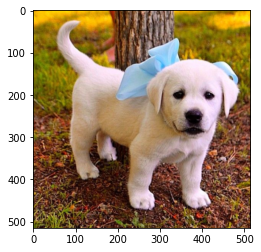

In [43]:
# 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요.
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## step2시맨틱 세그멘테이션.

In [44]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f5743472b20>)

In [45]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [46]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [47]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

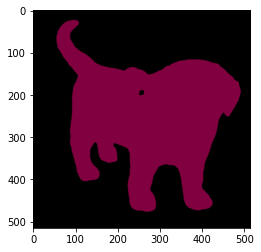

In [48]:
plt.imshow(output)
plt.show()

In [49]:
segvalues

{'class_ids': array([ 0, 12]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [50]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


In [51]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [52]:
colormap[12]

array([ 64,   0, 128])

In [53]:
seg_color = (128,0,64)

(515, 514)


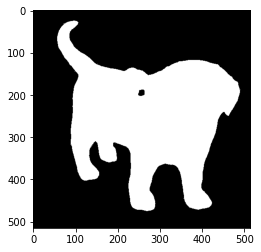

In [54]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

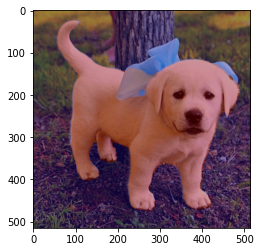

In [55]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## step3 배경흐리게 하기

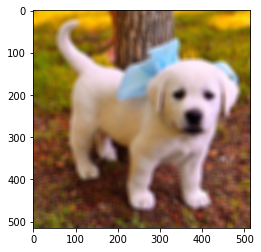

In [56]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

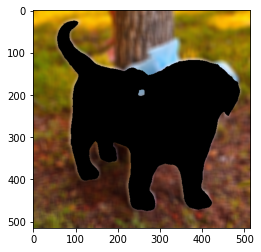

In [57]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## step4흐린 배경과 원본 영상 합성

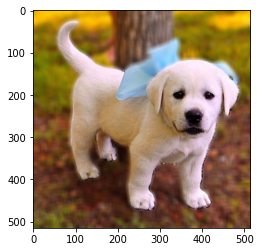

In [58]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


### ✔강아지 이미지에서 인물사진의 문제점을 알 수 있었습니다. 강아지는 잘 분리했지만 강아지목에 있는 리본은 인식하지 못하였고 몸에서 떨어진 부분은 블러처리가 되었습니다. 즉 강아지는 아니지만 강아지에 붙어있는 옷, 리본등을 인식하는데 문제점이 있구나 알 수 있었습니다.

# 3.크로마키사진(강아지, 하늘)

(515, 514, 3)


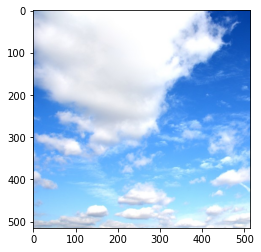

In [59]:
#하늘 이미지 가져오기
img_sky_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sky.png'  
img_sky = cv2.imread(img_sky_path) 
#사이즈 맞추기
img_sky_cut = img_sky[:515,:514]

print(img_sky_cut.shape)
plt.imshow(cv2.cvtColor(img_sky_cut, cv2.COLOR_BGR2RGB))
plt.show()

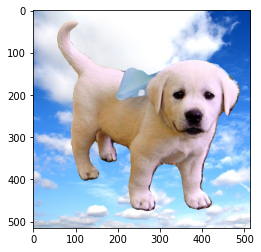

In [60]:
#강아지 이미지와 결합하기
img_concat = np.where(img_mask_color==255, img_orig, img_sky_cut)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


# 4. 회기

- 프로젝트에서 어려웠던점  
opencv에 대한 이해도가 떨어진 상태로 프로젝트를 이해하는데 어려움을 느꼈습니다.
- 프로젝트를 진행하면서 알아낸점 혹은 아직 모호한점  
np.where 의 의미에 대해 완벽하게 이해하였습니다. ex3 에서 np.where 부분이 나왔었는데 그 당시에는 이해하지 못했지만 이번 기회에 이해하였습니다. 그리고 사진을 불러오고, 저장하고, 자르는 방법도 알게 되었습니다.
- 루브릭 평가 지표를 맞추기 위해 시도한 것들  
mask 의 오류를 보완할 수 있는 술루션을 찾아보았는데, 이번 프로젝트를 할때 시간에 밀려서 잘 알아보지 못하였습니다.
- 만약에 루브릭 평가 관련 지표를 달성하지 못했을때 이유 추정  
이해도와 시간이 부족하였습니다.
- 자기다짐  
체력관리를 잘해서 노드를 밀리지 않고 해야겠습니다.